In [1]:
import json 
from collections import Counter
from tqdm import tqdm 
from colorama import Style,Fore
import os
from dotenv import load_dotenv
import time
load_dotenv()

True

In [2]:
from utils1 import openJson,saveJson

## Filtering 1

- videosF1.json contain the videos with fr-FR on the language parameter

In [ ]:
videosR3 = openJson("../jsons/videosR3.json")
len(videosR3)

In [ ]:
videosF1 = []
for video in videosR3:
    if video['langue']== 'fr-FR':
        videosF1.append(video)
saveJson("../jsons/videosF1.json",videosF1)
len(videosF1)

In [ ]:
videosF1 = openJson("../jsons/videosF1.json")
len(videosF1)

## Filtering 2

### Detecter les videos des Chaines TV 

In [ ]:
chainesTv = [
    "France 2", "France 3", "France 4","France 5","Franceinfo",
    "BFMTV", "C8", "CStar", "Gulli", "Cnews",
    "Canal+", "Plan√®te+", "LCI", "Paris premi√®re",
    "6ter", "Arte", "M6", "W9",
    "TFX", "TMC", "NRJ12", "TF1","La Cha√Æne parlementaire",
    "Ch√©rie 25", "RMC"
]
chainesTv = [nomTV.lower().replace(" ", "") for nomTV in chainesTv]

print(len(chainesTv))
print(chainesTv)

In [ ]:
videosF1 = openJson("../jsons/videosF1.json")
len(videosF1)

In [ ]:
channels = openJson("../../collecting/jsons/channels.json")
def getChannelName(channelId):
    for channel in channels:
        if channel['id_chaine']==channelId:
            return channel['nom_chaine'].lower().replace(" ", "")

In [ ]:
chainesTVCounter = Counter()
videosChainesTV = []
for video in videosF1:
    channelName = getChannelName(video['id_chaine'])
    for name in chainesTv:
        if name in channelName:  
            print(name,' ',channelName,' ',video['id_video'])
            chainesTVCounter[name]+=1
            videosChainesTV.append(video['id_video'])

In [ ]:
chainesTVCounter

In [ ]:
import matplotlib.pyplot as plt

labels = list(chainesTVCounter.keys())
sizes = list(chainesTVCounter.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, sizes, color='skyblue')

plt.title("R√©partition des vid√©os des cha√Ænes TV", fontsize=14)
plt.xlabel("Cha√Ænes TV", fontsize=12)
plt.ylabel("Nombre de vid√©os", fontsize=12)
plt.xticks(rotation=45, ha='right')

total_videos_tv = sum(sizes)
plt.text(len(labels) - 2, max(sizes) * 0.8, f"Total : {total_videos_tv} vid√©os", fontsize=12, ha='center')
plt.text(len(labels) - 2, max(sizes) * 0.74, "4.62% d'ensemble des vid√©os", fontsize=12, ha='center')

# Ajouter les nombres au-dessus des barres et les rendre en gras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{int(yval)}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
(218/len(videosF1))*100

### Creer videosF2.json

In [ ]:
videosChainesTV

In [ ]:
len(videosChainesTV)

In [ ]:
videosF2 = []
for video in videosF1:
    if video['id_video'] not in videosChainesTV:
        videosF2.append(video)
saveJson("../jsons/videosF2.json",videosF2)

verification

In [ ]:
len(videosF1)-len(videosF2)

In [ ]:
len(videosF1)

## Filtering 3

### With Embedding model

In [10]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("dangvantuan/sentence-camembert-base")

In [11]:
from sentence_transformers import util

def calculateSimilarity(videoMD, documents):
    embedding_video = model.encode([videoMD], convert_to_tensor=True, normalize_embeddings=True)
    embeddings_documents = model.encode(documents, convert_to_tensor=True, normalize_embeddings=True)
    scores = util.cos_sim(embedding_video, embeddings_documents)[0]
    simScore = scores.mean().item()
    return simScore


In [12]:
Vocabulary = openJson("../jsons/Voc.json")

def construire_phrases(mots_cles, taille=25):
    phrases = []
    for i in range(0, len(mots_cles), taille):
        groupe = mots_cles[i:i+taille]
        phrase = ' '.join(groupe)
        phrases.append(phrase)
    return phrases

documents = construire_phrases(Vocabulary)

In [ ]:
print(len(documents))
print(documents[7])

In [27]:
requete = """
On a test√© la cuisini√®re √† bois... Vous connaissez?
üôã‚Äç‚ôÇÔ∏èEt vous, vous √™tes-vous d√©j√† servi d'une cuisini√®re √† bois? Avez-vous des conseils √† nous donner pour garantir son utilisation et la s√©curit√© inh√©rente √† cet appareil ancestral? ‚ùî\n\n‚ûïLa cuisini√®re √† bois, c'√©tait clairement un bonus qu'on n'avait mis dans nos pr√©f√©rences en visitant la maison. On connaissait certains de ses avantages, mais en l'utilisant pour la premi√®re fois, non seulement on a √©t√© conquis, mais cette exp√©rience a r√©v√©l√© de nombreux points positifs qu'on ignorait. On vous raconte tout √ßa dans cette nouvelle vid√©o! \n\nüôÖ‚Äç‚ôÇÔ∏èJ'ai oubli√© d'√©voquer un des avantages dans cette vid√©o: PRENDRE LE TEMPS! C'est tellement bon de prendre plus de temps pour faire sensiblement la m√™me chose!\n\n‚úçÔ∏èOn a h√¢te d'avoir vos retours. Depuis cette vid√©o, on est retourn√©s une fois √† nos fourneaux pour f√™ter la Thanksgiving canadienne, et on a d√©finitivement adopt√© ce nouveau compagnon de route! En plus de tous les avantages cit√©s dans cette vid√©o, c'est ultra convivial!\n\nüòé Si c'est votre premi√®re fois, bienvenue sur notre cha√Æne. Ici on va parler autonomie bien s√ªr, mais transition en g√©n√©ral, que ce soit vers des nouveaux modes de consommation, vers d'autres mani√®res de voyager, vers un vivre-ensemble qui a du sens. En famille ou sans, c'est pareil, on est dans le m√™me bateau.\n\nBonne vid√©o, merci de nous soutenir en vous abonnant et √† tr√®s vite dans les commentaires!\n\n00:00 On n'y connaissait rien\n01:12 On pr√©sente le four (avant utilisation)\n02:55 Premier essai: Pain...\n05:37 ... et plein d'autres trucs (on optimise)\n06:54 On a ador√© cette premi√®re exp√©rience!\n07:50 On d√©guste. Vous venez?\n\n( Õ°‚ùõ‚ÄØ·¥ó Õ°‚ùõ)‚úä LA FAMILLE EN TRANSITION\n\n‚ù§ Abonne-toi √† la Cha√Æne pour ne rater aucune vid√©o https://www.youtube.com/channel/UC2M77RNyW6O9JQhpj1-6GOA\n‚úå Laisse-nous un pouce bleu si la vid√©o t'a plue\n\nContacte-nous √† lafamilleentransition@gmail.com",
 "#lafamilleentransition",
      "#LFET",
      "#Florian Gu√©ret",
      "#Cuisini√®re √† bois",
      "#comment cuisiner avec une cuisini√®re √† bois",
      "#bois de chauffage",
      "#cuisiner comme au bon vieux temps",
      "#cuisiner √† l'ancienne",
      "#cuisine",
      "#cuisiner au feu de bois",
      "#cuisine moderne",
      "#cuisine traditionnelle",
      "#transition",
      "#entransition",
      "#la famille",
      "#vlog famille",
      "#vlog",
      "#bretagne",
      "#pontivy",
      "#√† l'abri de la pluie",
      "#comment cuisiner du pain",
      "#comment faire son pain en cocotte",
      "#faire son pain en baguette"
"""


calculateSimilarity(requete,contexte_autosuffisance)

0.10253167897462845

#### Keywords VS Video Metadata

In [ ]:
videosF2 = openJson("../jsons/videosF2.json")

scores = []
for video in tqdm(videosF2):
    context = video['titre_video'] + video['description'] + ' '.join(video['tags'])
    score = calculateSimilarity(context,documents)
    print(score,'  ',video['id_video'])
    scores.append(
        {
            'id_video':video['id_video'],
            'similarity':score
        }
    )

saveJson("../jsons/keywordsVsMTD.json",scores)

- Analyzing

In [20]:
keywordsVsMTD = openJson("../jsons/keywordsVsMTD.json")
len(keywordsVsMTD)

1100

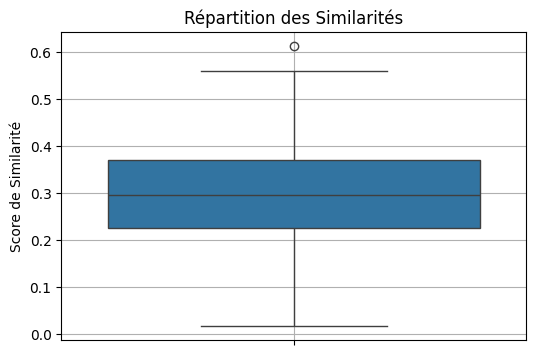

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

similarites = [item["similarity"] for item in keywordsVsMTD]

plt.figure(figsize=(6, 4))
sns.boxplot(y=similarites)
plt.title('R√©partition des Similarit√©s')
plt.ylabel('Score de Similarit√©')
plt.grid(True)
plt.show()


In [22]:
similarites = [item["similarity"] for item in keywordsVsMTD]

nombre_total = len(similarites)
nombre_sup_015 = sum(s > 0.15 for s in similarites)
pourcentage_sup_015 = (nombre_sup_015 / nombre_total) * 100

print(f"Nombre de vid√©os avec similarit√© > 0.15 : {nombre_sup_015}")
print(f"Pourcentage : {pourcentage_sup_015:.2f}%")


Nombre de vid√©os avec similarit√© > 0.15 : 1039
Pourcentage : 94.45%


In [28]:
llmEvaluation = openJson("../jsons/llmEvaluation.json")
len(llmEvaluation)

1100

In [33]:
videos_sous_015 = [item for item in keywordsVsMTD if item["similarity"] <= 0.15]
videos_sous_015 = sorted(videos_sous_015, key=lambda x: x["similarity"])

videos_sur_015 = [item for item in keywordsVsMTD if item["similarity"] > 0.15]
videos_sur_015 = sorted(videos_sur_015, key=lambda x: x["similarity"])

In [31]:
for v in videos_sous_015:
    for Eval in llmEvaluation:
        if Eval['id_video']==v['id_video'] and Eval['decision']=='oui':
            print(v)
            print(Eval)
            print("\n")

{'id_video': 'Yc24O1r7FfU', 'similarity': 0.01691398024559021}
{'id_video': 'Yc24O1r7FfU', 'decision': 'oui', 'justification': 'Le titre mentionne une m√©thode de fabrication de lessive √† partir de cendre, ce qui est une technique permettant de subvenir √† un besoin (laver son linge) de mani√®re autonome.', 'score': 7}


{'id_video': 'iaUboIY9X4Q', 'similarity': 0.016999468207359314}
{'id_video': 'iaUboIY9X4Q', 'decision': 'oui', 'justification': "Le titre sugg√®re une production agricole importante, ce qui est un √©l√©ment cl√© de l'autosuffisance alimentaire. Bien qu'il manque une description et des tags, le titre est suffisamment pertinent pour indiquer un lien avec la th√©matique.", 'score': 6}


{'id_video': 'qePUdJIw0Z4', 'similarity': 0.04405586048960686}
{'id_video': 'qePUdJIw0Z4', 'decision': 'oui', 'justification': 'Le titre "Habitat R√©silient" sugg√®re une approche visant √† cr√©er un lieu de vie autonome et durable, ce qui est un aspect central de l\'autosuffisance. Bien 

In [34]:
for v in videos_sur_015:
    for Eval in llmEvaluation:
        if Eval['id_video']==v['id_video'] and Eval['decision']=='non':
            print(v)
            print(Eval)
            print("\n")

{'id_video': 'CDBkv2Az8RY', 'similarity': 0.1502985656261444}
{'id_video': 'CDBkv2Az8RY', 'decision': 'non', 'justification': "La vid√©o parle de l'autonomie des jeunes handicap√©s, ce qui est diff√©rent de l'autosuffisance (qui se concentre sur la capacit√© √† subvenir √† ses besoins fondamentaux par soi-m√™me, notamment alimentaires).", 'score': 2}


{'id_video': '6LEvKg8qKao', 'similarity': 0.15943597257137299}
{'id_video': '6LEvKg8qKao', 'decision': 'non', 'justification': 'La vid√©o traite du financement de l\'autonomie des retrait√©s, un sujet li√© √† la politique et au financement de la d√©pendance, mais pas directement √† l\'autosuffisance telle que d√©finie (production de sa propre nourriture, r√©duction de la d√©pendance au syst√®me √©conomique). Le terme "autonomie" est utilis√© ici dans un sens diff√©rent.', 'score': 2}


{'id_video': 'BMuf64URw5E', 'similarity': 0.1608438789844513}
{'id_video': 'BMuf64URw5E', 'decision': 'non', 'justification': "La vid√©o semble √™tre une 

In [32]:
videos_sous_015 = [item for item in keywordsVsMTD if item["similarity"] <= 0.15]
videos_sous_015 = sorted(videos_sous_015, key=lambda x: x["similarity"])

for item in videos_sous_015:
    print(f"ID vid√©o: {item['id_video']} - Similarit√©: {item['similarity']:.4f}")
for item in keywordsVsMTD:
    if item["similarity"] <= 0.15:
        print(f"ID vid√©o: {item['id_video']} - Similarit√©: {item['similarity']:.4f}")


ID vid√©o: Yc24O1r7FfU - Similarit√©: 0.0169
ID vid√©o: iaUboIY9X4Q - Similarit√©: 0.0170
ID vid√©o: wL_7d-gH7ek - Similarit√©: 0.0231
ID vid√©o: 7xPUcKSaU-k - Similarit√©: 0.0254
ID vid√©o: qePUdJIw0Z4 - Similarit√©: 0.0441
ID vid√©o: KYHEJVVgxg8 - Similarit√©: 0.0447
ID vid√©o: lSoWicUMVlM - Similarit√©: 0.0483
ID vid√©o: nNK2KRrjj1s - Similarit√©: 0.0626
ID vid√©o: SrFPFZ14loQ - Similarit√©: 0.0628
ID vid√©o: uIib2jT2r3w - Similarit√©: 0.0688
ID vid√©o: SGslcr5UEwQ - Similarit√©: 0.0723
ID vid√©o: p7P39qBv9J4 - Similarit√©: 0.0743
ID vid√©o: 8SW7OsOWlRY - Similarit√©: 0.0766
ID vid√©o: De1X6ThCx9k - Similarit√©: 0.0802
ID vid√©o: ZYI5bSJK1tU - Similarit√©: 0.0840
ID vid√©o: 7pNeqTZuT7E - Similarit√©: 0.0862
ID vid√©o: e-UlGJIa6RI - Similarit√©: 0.0904
ID vid√©o: jhs5BvrlT88 - Similarit√©: 0.1013
ID vid√©o: 7JIDkOO9PP0 - Similarit√©: 0.1028
ID vid√©o: 2grH3e2-LxA - Similarit√©: 0.1060
ID vid√©o: iDIIKfmqNZ8 - Similarit√©: 0.1102
ID vid√©o: Npz3P9yABz8 - Similarit√©: 0.1103
ID vid√©o:

In [25]:
contexte_autosuffisance = [
    "Potager familial productif pour l'autonomie en l√©gumes",
    "√âlevage de poules, moutons et canards pour l‚Äôautonomie alimentaire",
    "Utilisation de plantes m√©dicinales et aromatiques cultiv√©es sur place",
    "R√©cup√©ration et filtration de l'eau via un puits et osmose inverse",
    "Construction de bacs permacoles faits maison pour une culture efficace",
    "Transformation du sol en terre fertile pour maximiser les rendements",
    "Vie en sobri√©t√© heureuse et respect de la nature",
    "Utilisation de semences locales et choix vari√©tal r√©fl√©chi",
    "Production locale de viande, ≈ìufs et l√©gumes",
    "Utilisation d'une serre pour prolonger les cultures",
    "M√©tiers artisanaux (√©b√©nisterie, photographie culinaire) int√©gr√©s dans le mode de vie",
    "Conception d‚Äôun lieu de vie en autonomie √©nerg√©tique et alimentaire"
]


In [ ]:
videosF2 = openJson("../jsons/videosF2.json")
scores = {}
for video in tqdm(videosF2):
    context = video['titre_video'] + video['description'] + ' '.join(video['tags'])
    score = calculateSimilarity(context,documents)
    print(score,'  ',video['id_video'])
    scores[video['id_video']]=score


In [ ]:
videosF2 = openJson("../jsons/videosF2.json")
scores = {}
for video in tqdm(videosF2):
    context = video['titre_video'] + video['description'] + ' '.join(video['tags'])
    score = calculateSimilarity(context,contexte_autosuffisance)
    print(score,'  ',video['id_video'])
    scores[video['id_video']]=score


### LLM Scoring

In [ ]:
from langchain_google_genai import GoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
gemini_flash_1 = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY_1"))
gemini_flash_2 = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY_2"))

In [ ]:
sysprompt = """
# La definition d'autossuffinnce

L'autosuffisance est la d√©marche visant √† acqu√©rir la capacit√© de subvenir par soi-m√™me √† ses besoins fondamentaux, 
en premier lieu alimentaires par l'autoconsommation ‚Äì c'est-√†-dire produire, r√©colter et conserver un maximum de sa propre nourriture, 
souvent en privil√©giant le bio, le local et le saisonnier. Plus qu'une simple recherche d'autonomie mat√©rielle, 
elle repr√©sente un engagement pour √™tre moins d√©pendant du syst√®me √©conomique et social ext√©rieur, impliquant des choix concrets comme trouver un lieu propice et le concevoir judicieusement (par exemple en permaculture), 
ainsi qu'un changement dans la mani√®re de valoriser son temps et de consommer, formant ainsi le fondement d'une vie plus autonome.

---

# Votre mission

- D√©cider si une vid√©o concerne la th√©matique de l'autosuffisance en se basant sur ses m√©tadonn√©es (titre, description, tags).  
- Les vlogs, les interviews et les vid√©os de partage d'exp√©riences en lien avec l'autosuffisance sont int√©ressants.  
- Les tutoriels et les vid√©os de conseils sont √©galement pertinents.  
- Les vid√©os pr√©sentant une technique li√©e √† l'autosuffisance ou y contribuant sont utiles.  
- Attribuer un score entier de 1 √† 10 pour √©valuer la pertinence de la vid√©o par rapport √† la th√©matique de l'autosuffisance.

---

# Votre r√©ponse  

- La r√©ponse doit √™tre au format JSON :  
  
    "decision": "oui ou non",
    "justification": "Justifiez votre d√©cision avec des arguments"
    "score": votre √®valuation
 
"""

userprompt = """
Titre
---
{titre}
Description
---
{description}
tags
---
{tags}
"""

prompt = ChatPromptTemplate([
    ("system", sysprompt),
    ("user", userprompt)
])

chain_1 = prompt | gemini_flash_1
chain_2 = prompt | gemini_flash_2


- Test

In [ ]:
input = {"titre":"Tuteurer et redresser un arbre üå≥",
         "description":"Dans cette vid√©o nous allons voir ensemble comment mettre un tuteur afin de redresser un arbre qui penche suite √† la temp√™te.\nCette vid√©o vous aideras pour placer un tuteur en travers , sangler un arbre selon le sens du vent,\n\nIl existe plusieurs facon de tuteurer un arbre, haubanage, tripode,.. mais dans le cas pr√©sent un tuteur en biais suffiras puisque l'arbre n'est pas tr√©s gros.\n\n\n‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨ POUR ALLER PLUS LOIN  ‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨\n\nüí° Abonnez-vous pour me soutenir üß°\n\n\nüí°Rejoignez-nous sur twitter\net tik tok\n\n\n‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨ CHAPITRES DE CETTE VID√âO ‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨\n\n00:00 : Introduction\n00:23 : Mise en place tuteur\n01:54 : Sanglage et Redresser l'arbre\n02:54 : Sens du vent et d√©tails tuteurage\n\n‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨ A PROPOS DE CETTE VID√âO ‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨‚ñ¨\n\nLe Jardin du moulin\nFrancois\n#potager #jardindumoulin",
         "tags":', '.join( [
      "TCS",
      "Agriculture Biologique",
      "Bio",
      "GAB 85",
      "FNAB",
      "Vend√©e",
      "Techniques Culturales Simplifi√©es",
      "GAEC Les Jonquilles",
      "ECOPHYTO",
      "Demain Vend√©e",
      "Conservation des sols",
      "Sol vivant",
      "Productions v√©g√©tales",
      "Ma√Øs"
    ])}
print(input)
print(chain_2.invoke(input))

In [ ]:
def cleanAnswer(answer):
    answer = answer.strip("`")   # Supprimer tous les backticks
    if answer.startswith("json"):
        answer = answer[4:].strip() 
    return  answer

In [ ]:
videosF2 = openJson("../jsons/videosF2.json")
llmEvaluation = []
count1 = 0
count2 = 0
temp = 0

for video in tqdm(videosF2):
    input = {"titre":video['titre_video'],
             "description":video['description'],
             "tags":', '.join(video['tags']),}
    try:
        if count1  <= 13:
            print("KEY 1")
        
            answer = cleanAnswer(chain_1.invoke(input))
            #print(video['id_video'],'/n',answer)
            evaluation = {}
            evaluation['id_video']=video['id_video']
            evaluation.update(json.loads(answer))
            llmEvaluation.append(evaluation)
            
            count1+=1
            temp+=1            
             
            print("count1 ",count1)  
            
        if count1  > 13 and count2 <= 13:
            print("KEY 2")
            
            answer =  cleanAnswer(chain_2.invoke(input))
            #print(video['id_video'],'/n',answer)
            evaluation = {}
            evaluation['id_video']=video['id_video']
            evaluation.update(json.loads(answer))
            llmEvaluation.append(evaluation)
            
            count2+=1
            temp+=1
            print("count2 ",count2)  
            
        if count1 > 13 and count2 > 13 :
            print("sleep for 1 min")
            time.sleep(60)
            count1 = 0
            count2 = 0
        

        if temp >= 100:
            saveJson("../jsons/llmEvaluation.json",llmEvaluation)
            temp=0
            
    except Exception as e:
        print(f"error {e}")

- Seperate the videos classified as not relevent

In [36]:
llmEvaluations = openJson("../jsons/llmEvaluation.json")
videosF2 = openJson("../jsons/videosF2.json")

def getNonVideo(ID):
    for video in videosF2:
        if video['id_video']==ID:
            return video

In [ ]:
len(videosF2)

In [ ]:
len(llmEvaluations)

In [ ]:
videosNon = []
for evaluation in llmEvaluations:
    try:

        if evaluation['decision'] =='non':
            videoNo = getNonVideo(evaluation['id_video'])
            videoNo.update(evaluation)
            videosNon.append(videoNo)
    except:
        print(evaluation)
        break
    
saveJson("../jsons/llmVideosNon.json",videosNon)

In [ ]:
len(videosNon)